In [1]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time
import random
from scipy.linalg import block_diag
from sklearn.metrics import precision_recall_curve, auc
import scipy.stats
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import random
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
from collections import defaultdict

import sys
# sys.path.append('/Users/yijwang-admin/Documents/Research/GFL/Code/PQN_Python_main')
from minConf.minConf_PQN import minConF_PQN
import random
import itertools
import os
import matlab.engine
from sklearn.linear_model import Lasso

In [68]:
class RandomEnsemble:
    def __init__(self, n, d, k, h_total, h_selected, h_rest, gamma, 
                 p=0.95, q=0.01, 
                 options=None, num_replications=20,
                 datafile=f'./code_fgfl_aaai14/data_gfl/',
                 resultfile='./code_fgfl_aaai14/result_gfl/',
                 models=None):
        assert h_total == h_selected + h_rest, "h_total should be equal to h_selected + h_rest"
        self.n = n
        self.d = d
        self.k = k
        self.h_total = h_total
        self.h_selected = h_selected
        self.h_rest = h_rest
        self.gamma = gamma
        self.p = p
        self.q = q
        self.options = options if options else {'maxIter': 500, 'verbose': 0, 'SPGiters': 100}
        self.num_replications = num_replications
        self.datafile = os.path.join(os.path.abspath(datafile), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self.resultfile = os.path.join(os.path.abspath(resultfile), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}') # matlab does not like relative path
        self.best_rho1 = 0.5
        self.best_rho2 = 0.5
        self.best_mu = 1.0
        # self.best_rho = np.sqrt(self.n) * 6.8
        self.best_rho = np.sqrt(self.n)
        self.datafile_pqn = os.path.join(os.path.abspath('./PQN/data/'), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self.resultfile_pqn = os.path.join(os.path.abspath('./PQN/result/'), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self._init(self.datafile, self.resultfile)
        self._init(self.datafile_pqn, self.resultfile_pqn)
        self.models = models

    
    def _init(self, datafile, resultfile):
        if not os.path.exists(datafile):
            os.makedirs(datafile)
        if not os.path.exists(resultfile):
            os.makedirs(resultfile)

    def _random_partition(self):
        # partition the first k nodes into h_selected groups and the rest into h_rest groups
        assert self.h_selected <= self.k, "h_selected should be less than k"
        assert self.h_rest <= self.d - self.k, "h_rest should be less d-k"
        if self.k % self.h_selected != 0 or (self.d - self.k) % self.h_rest != 0:
            break_points = np.sort(random.sample(range(1, self.k), self.h_selected-1))
            break_points_rest = np.sort(random.sample(range(self.k+1, self.d), self.h_rest-1))
        else: # evenly divide the nodes
            break_points = np.arange(self.k // self.h_selected, self.k, self.k // self.h_selected)
            break_points_rest = np.arange(self.k + (self.d - self.k) // self.h_rest, self.d, (self.d - self.k) // self.h_rest)
            
        return break_points, break_points_rest
    
    def _generate_clusters(self):
        if self.h_selected == 1 and self.h_rest == 1:
            clusters = [np.arange(self.k)]
            clusters.append(np.arange(self.k, self.d))
        else:
            break_points, break_points_rest = self._random_partition()
            clusters = []
            clusters.append(np.arange(break_points[0])) # first selected cluster
            for i in range(1, self.h_selected-1):
                clusters.append(np.arange(break_points[i-1], break_points[i]))
            clusters.append(np.arange(break_points[-1], self.k)) # last selected cluster

            clusters.append(np.arange(self.k, break_points_rest[0])) # first rest cluster
            for i in range(1, self.h_rest-1):
                clusters.append(np.arange(break_points_rest[i-1], break_points_rest[i]))
            clusters.append(np.arange(break_points_rest[-1], self.d))

        return clusters

    def _generate_graph(self):
        # here we generate the adjacency matrix and laplacian of the graph
        clusters = self._generate_clusters()

        A = sp.lil_matrix((self.d, self.d))
        
        # generate thr inner cluster connections
        for cluster in clusters:
            cluster_size = len(cluster)
            block = (np.random.rand(cluster_size, cluster_size) < self.p).astype(int)
            np.fill_diagonal(block, 0) # no self-loop
            block = np.triu(block) + np.triu(block, 1).T # make it symmetric
            for i, node_i in enumerate(cluster):
                for j, node_j in enumerate(cluster):
                    A[node_i, node_j] = block[i, j]

        # generate the connections between clusters
        for i in range(self.h_total):
            for j in range(i+1, self.h_total):
                cluster_i = clusters[i]
                cluster_j = clusters[j]
                block = (np.random.rand(len(cluster_i), len(cluster_j)) < self.q).astype(int)
                for m, node_i in enumerate(cluster_i):
                    for n, node_j in enumerate(cluster_j):
                        A[node_i, node_j] = block[m, n]
                        A[node_j, node_i] = block[m, n]

        # TODO: check if the graph is connected and make it connected if not 
        # (optional, maybe not necessary)
        D = sp.diags(np.ravel(A.sum(axis=1)))
        L = D - A
        return L, clusters, A
    
    def _visualize_graph(self, A):
        # if we want to visualize the graph, we need to change it to array rather than sparse matrix
        A_arr = A.toarray()
        plt.figure(figsize=(8, 8))
        plt.title('Adjacency matrix')
        plt.spy(A_arr)
        plt.axis('off')
        plt.show()

    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        for i in range(self.h_selected):
            cluster_sign = np.random.choice([-1, 1])
            cluster_weight = cluster_sign * (1 / np.sqrt(self.k)) # TODO: make more choice other than 1/sqrt(k)
            for node in clusters[i]:
                w[node] = cluster_weight
        # w = w[:, np.newaxis]
        return w

    def _generate_X(self):
        # X = np.random.normal(0, 1, (self.n, self.d))
        mean = np.zeros(self.d)
        cov = np.eye(self.d)
        X = np.random.multivariate_normal(mean, cov, self.n)
        return X
    
    def _generate_y(self, X, w):
        signal = X @ w
        noise = np.random.normal(0, self.gamma, signal.shape)
        y = signal + noise
        SNR = self._compute_snr(signal, noise)
        if 0: # TODO: add a debug/verbose flag
            print(f'SNR: {SNR}')

        return y

    def _generate_data(self):
        L, clusters, A = self._generate_graph()
        if 0: # TODO: add a debug/verbose flag 
            self._visualize_graph(A)
        w = self._generate_w(clusters)
        X = self._generate_X()
        y = self._generate_y(X, w)
        return L, w, X, y, clusters, A


    def _compute_snr(self, signal, noise):  
        # in our case, the snr is 10*log10(1/gamma^2)
        signal = np.asarray(signal)
        noise = np.asarray(noise)

        signal_power = np.mean(signal ** 2)
        noise_power = np.mean(noise ** 2)
        
        snr = signal_power / noise_power
        snr_db = 10 * np.log10(snr)
        
        return snr_db
    
    def _define_obj(self, model, X, y, rho=1, L=None, mu=None):
        """
        Support models: 'Lasso', GroupLasso', 'GeneralizedFusedLasso'
        I plan to support Proximal method by calling matlab session
        this part and the one below is to support PQN, the Proxiaml method is on its own, it does not need this
        """
        if model == "Lasso":
            return lambda u: Lasso(u, X, y, rho)
        elif model == "GroupLasso":
            return lambda u: GroupLasso(u, X, y, rho)
        elif model == "GeneralizedFusedLasso":
            return lambda u: GeneralizedFusedLasso(u, X, y, rho, L, mu)
        else:
            raise ValueError("Model not supported")
        
    def _define_projection(self, model, groups=None):
        """
        Support models: 'Lasso', GroupLasso', 'GeneralizedFusedLasso'
        """
        if model == "Lasso":
            return lambda u: ProjLassoGurobi(u, self.k, self.d)
        elif model == "GroupLasso":
            return lambda u: ProjGroupLassoGurobi(u, self.k, groups, self.h_selected, self.d)
        elif model == "GeneralizedFusedLasso":
            return lambda u: ProjGeneralizedFusedLassoGurobi(u, self.k, self.d)
        else:
            raise ValueError("Model not supported")
        
    def _max_degree(self, L):
        # find the maximum degree of the graph according to the laplacian matrix
        return np.max(np.diag(L.toarray()))
    
    def solver(self, model, X, y, clusters=None, L=None, A=None, i=None, rho=1, mu=1):
        if model == "Proximal":
            return self._solver_proximal(X, y, A, i)
        elif model == "Lasso":
            rho = np.sqrt(self.n) # TODO: check if this is the correct value
            # funObj = self._define_obj(model, X, y, rho)
            # funProj = self._define_projection(model)
            return self._solver_gfl(X, y, L, i, rho, mu=0.0)
        elif model == "GroupLasso":
            rho = np.sqrt(self.n) # TODO: check if this is the correct value
            funObj = self._define_obj(model, X, y, rho)
            funProj = self._define_projection(model, clusters)
        elif model == "GeneralizedFusedLasso":
            # max_degree = self._max_degree(L)
            # rho = 3.4 * self.k * 2 * mu * 2 * max_degree  # TODO: check if this is the correct value
            # rho = np.sqrt(self.n) # TODO: check if this is the correct value
            if i == 0:
                # rho_values = [1, 10, np.sqrt(self.n), 50, 70, 100] # sqrt(300)=17.32
                # rho_values = [10, np.sqrt(self.n), 50, 100]
                rho_values = [0.1, 0.5, 1.0, 5.0]
                mu_values = [0.01, 0.1, 1.0]
                self.best_rho, self.best_mu = self._cross_validation_gfl(X, y, L, rho_values, mu_values)
            else:
                rho = self.best_rho
                mu = self.best_mu
            funObj = self._define_obj(model, X, y, rho, L, mu)
            funProj = self._define_projection(model)
        elif model == "GFL_Matlab":
            # rho = np.sqrt(self.n) # TODO: check if this is the correct value
            # mu = 1.0
            return self._solver_gfl(X, y, L, i)
        elif model == "Lasso_Sklearn":
            return self._solver_lasso_sklearn(X, y)
        else:
            raise ValueError("Model not supported")
        
        uSimplex = np.ones((self.d, 1)) / self.d
        uout, obj, _ = minConF_PQN(funObj, uSimplex, funProj, self.options)
        # uout = funProj(uout) # TODO: check if this is necessary

        self._save_result(uout, f'./res/result_{model}_{i}.mat')

        return uout
    
    def _solver_lasso_sklearn(self, X, y):
        """
        Use sklearn's Lasso implementation to solve the Lasso problem.
        """
        alpha = 0.1
        lasso_model = Lasso(alpha=alpha, max_iter=10000)  # Lasso model with high max_iter
        lasso_model.fit(X, y)  # Fit the model
        u = lasso_model.coef_  # Get the coefficients
        # print(f"Lasso coefficients: {u}")
        return u
    
    def _solver_gfl(self, X, y, L, i, rho=None, mu=None):
        datafile_pqn = os.path.join(self.datafile_pqn, f'data_{i}.mat')
        resultfile_pqn = os.path.join(self.resultfile_pqn, f'result_{i}.mat')
        if rho is None or mu is None: # we don't need to store the data when we do Lasso
            self._save_mat_pqn(X, y, L, datafile_pqn)
        if rho is None or mu is None:
            if i == 0:
                rho_values = [np.sqrt(self.n), 6.8 * np.sqrt(self.n)]
                mu_values = [0.01, 0.1, 1.0]
                self.best_rho, self.best_mu = self._cross_validation_gfl(X, y, L, rho_values, mu_values)
                print(f"Best rho: {self.best_rho}, Best mu: {self.best_mu}")
            rho = self.best_rho
            mu = self.best_mu

        self._call_gfl(datafile_pqn, resultfile_pqn, rho, mu)
        u, _ = self._read_result(resultfile_pqn)
        return u.flatten()
    
    def _save_mat_pqn(self, X, y, L, filename=None):
        # save the data to .mat file so that the matlab code of proxiaml can use it
        # print("X.shape", X.shape)   
        # print("y.shape", y.shape)
        # print("A.shape", A.shape)
        if y.ndim == 1:
            y = y[:, np.newaxis]
        data = {
            "X": X,
            "y": y,
            "L": L.toarray() if sp.issparse(L) else L,  # we store the adjacency matrix as dense matrix
        }
        sio.savemat(filename, data)

    
    def _call_gfl(self, datafile, resultfile, rho, mu):
        eng = matlab.engine.start_matlab()
        try:
            eng.cd(os.path.abspath('./PQN/'))
            eng.addpath(os.path.abspath('./PQN/'))
            eng.addpath(eng.genpath(os.path.abspath('./PQN/')))
            eng.addpath(eng.genpath(os.path.abspath('./PQN/minConF/')))
            eng.gfl_pqn(datafile, resultfile, rho, mu, float(self.k), nargout=0)
        finally:
            eng.quit()
    
    def _save_result(self, u, filename):
        sio.savemat(filename, {'beta': u})
    
    def _gfl_helper(self, X, y, L, rho, mu):
        funObj = self._define_obj("GeneralizedFusedLasso", X, y, rho, L, mu)
        funProj = self._define_projection("GeneralizedFusedLasso")
        uSimplex = np.ones((self.d, 1)) / self.d
        uout, obj, _ = minConF_PQN(funObj, uSimplex, funProj, self.options)
        uout = funProj(uout) # TODO: check if this is necessary

        return uout

    
    def _call_proximal(self, datafile, resultfile, rho1, rho2):
        eng = matlab.engine.start_matlab()
        try:
            eng.cd(os.path.abspath('./code_fgfl_aaai14/'))
            eng.addpath(os.path.abspath('./code_fgfl_aaai14/GFL/'))
            eng.addpath(eng.genpath(os.path.abspath('./code_fgfl_aaai14/')))
            eng.gfl_proximal(datafile, resultfile, rho1, rho2, nargout=0)
        finally:
            eng.quit()

    def _cross_validation(self, X, y, A, rho1_values, rho2_values, k_folds=5):
        results = []
        n = self.n
        indices = np.arange(n)
        np.random.shuffle(indices)
        folds = np.array_split(indices, k_folds)
        datafile = os.path.join(self.datafile, 'data.mat') 
        resultfile = os.path.join(self.resultfile, 'result.mat')

        for rho1, rho2 in itertools.product(rho1_values, rho2_values):
            mse_list = []
            for fold in folds:
                train_indices = np.setdiff1d(indices, fold)
                test_indices = fold
                X_train, y_train = X[train_indices], y[train_indices]
                X_test, y_test = X[test_indices], y[test_indices]

                self._save_mat(X_train, y_train, A, datafile)
                self._call_proximal(datafile, resultfile, rho1, rho2)
                u, funcVal = self._read_result(resultfile)      
                mse = np.mean((X_test @ u - y_test) ** 2)
                mse_list.append(mse)

            avg = np.mean(mse_list)
            results.append((rho1, rho2, avg))

        best_rho1, best_rho2, _ = min(results, key=lambda x: x[2])
        return best_rho1, best_rho2
    
    def _cross_validation_gfl(self, X, y, L, rho_values, mu_values, k_folds=5):
        results = []
        n = self.n
        indices = np.arange(n)
        np.random.shuffle(indices)
        folds = np.array_split(indices, k_folds)
        datafile = os.path.join(self.datafile_pqn, 'data.mat')
        resultfile = os.path.join(self.resultfile_pqn, 'result.mat')

        for rho, mu in itertools.product(rho_values, mu_values):
            acc_list = []
            for fold in folds:
                train_indices = np.setdiff1d(indices, fold)
                test_indices = fold
                X_train, y_train = X[train_indices], y[train_indices]
                # X_test, y_test = X[test_indices], y[test_indices]
                self._save_mat_pqn(X_train, y_train, L, datafile)
                self._call_gfl(datafile, resultfile, rho, mu)
                u, _ = self._read_result(resultfile)
                u = u.flatten()
                acc_score = self.recovery_accuracy(u)
                acc_list.append(acc_score)
                

            avg = np.mean(acc_list)
            results.append((rho, mu, avg))
            print(f"rho: {rho}, mu: {mu}, acc: {avg}")
        
        
        best_rho, best_mu, _ = max(results, key=lambda x: x[2])
        # print(f"Best rho: {best_rho}, Best mu: {best_mu}")
        return best_rho, best_mu

    def _read_result(self, resultfile):
        result = sio.loadmat(resultfile)
        beta, funcVal = result['beta'], result['funcVal']
        return beta, funcVal
        
    def _solver_proximal(self, X, y, A, i):
        # rho1_values = [0.1, 0.5, 1.0, 5.0]
        # rho2_values = [0.1, 0.5, 1.0, 5.0]
        # if i == 0: # we only do cross validation once and use the best rho1 and rho2 for the rest of the replications
        #     self.best_rho1, self.best_rho2 = self._cross_validation(X, y, A, rho1_values, rho2_values)
        #     print(f"Best rho1: {self.best_rho1}, Best rho2: {self.best_rho2}")

        datafile_name = os.path.join(self.datafile, f'data_{i}.mat')
        resultfile_name = os.path.join(self.resultfile, f'result_{i}.mat')
        self._save_mat(X, y, A, datafile_name)
        self._call_proximal(datafile_name, resultfile_name, self.best_rho1, self.best_rho2)
        u, funcVal = self._read_result(resultfile_name)
        return u.flatten() # the original return a vector with shape (d,1), will not work with recovery_accuracy

    def recovery_accuracy(self, u):
        # evaluate the support recovery accuracy
        # we take top k for u
        selected_features_true = np.arange(self.k)
        selected_features_pred = np.argsort(np.abs(u))[-self.k:] # take absolute value for proximal method
        correct_pred = np.intersect1d(selected_features_true, selected_features_pred)
        accuracy = len(correct_pred) / self.k
        return accuracy
    
    def _save_mat(self, X, y, A, filename=None):
        # save the data to .mat file so that the matlab code of proxiaml can use it
        # print("X.shape", X.shape)   
        # print("y.shape", y.shape)
        # print("A.shape", A.shape)
        if y.ndim == 1:
            y = y[:, np.newaxis]
        data = {
            "X": X,
            "y": y,
            "AdjMat": A.toarray() if sp.issparse(A) else A,  # we store the adjacency matrix as dense matrix
        }
        sio.savemat(filename, data)

    def _report(self, model_accuracy):
        for model, accuracy in model_accuracy.items():
            avg_accuracy = np.mean(accuracy)
            std_accuracy = np.std(accuracy)
            print(f"Model: {model}, Avg. Accuracy: {avg_accuracy}, Std. Accuracy: {std_accuracy}")

    def main(self):
        # models = ["Proximal", "Lasso", "GroupLasso", "GeneralizedFusedLasso"]
        # models = ["GeneralizedFusedLasso", "Proximal"]
        if self.models is None:
            models = ["GFL_Matlab", "Lasso", "Proximal", "Lasso_Sklearn"]
        else:
            models = self.models
        # models = ["Lasso_Sklearn"]
        model_accuracy = defaultdict(list)
        for i in range(self.num_replications):
            L, w, X, y, clusters, A = self._generate_data()
            for model in models:
                print(f"Synthetic dataset {i+1}: Running {model} model")
                u = self.solver(model, X, y, clusters, L, A, i)
                accuracy = self.recovery_accuracy(u)
                model_accuracy[model].append(accuracy)

        self._report(model_accuracy)
        return model_accuracy
    
# TODO: solve the orginal problem and calculate the MSE?


class RandomEnsembleWeight(RandomEnsemble):
    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        cluster_weights = []

        # Generate non-zero random weights for clusters
        for _ in range(self.h_selected):
            cluster_sign = np.random.choice([-1, 1])
            cluster_weight = cluster_sign * (1 / np.sqrt(self.k))
            cluster_weights.append(cluster_weight)

        # Generate zero weights for the rest of the clusters
        for _ in range(self.h_rest):
            cluster_weights.append(0)

        for i in range(self.h_total):
            for node in clusters[i]:
                w[node] = cluster_weights[i] + np.random.normal(0, 0.1* np.abs(cluster_weights[i]))  # we allow weights in the same cluster to be slightly different

        return w
    
class RandomEnsembleCorrelation(RandomEnsemble):
    def _generate_X(self):
        mean = np.zeros(self.d)
        cov = np.eye(self.d)
        # for the correlated case, we find some correlation between the selected features and non-selected features
        correlated_ratio = 0.3
        selected_features = np.arange(self.k)
        non_selected_features = np.arange(self.k, self.d)

        correlated_pairs = []
        selected_features_correlated = random.sample(list(selected_features), int(correlated_ratio * self.k))
        non_selected_features_correlated = random.sample(list(non_selected_features), int(correlated_ratio * self.k))
        for i in selected_features_correlated:
            for j in non_selected_features_correlated:
                correlated_pairs.append((i, j))
        
        for i, j in correlated_pairs:
            cov[i, j] = 0.9
            cov[j, i] = 0.9

        eigvals, eigvecs = np.linalg.eigh(cov)
        eigvals = np.maximum(eigvals, 0)  # Set negative eigenvalues to zero
        cov = eigvecs @ np.diag(eigvals) @ eigvecs.T

        X = np.random.multivariate_normal(mean, cov, self.n)
        return X
    
class RandomEnsembleCorrelationWeight(RandomEnsemble):
    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        cluster_weights = []

        # Generate non-zero random weights for clusters
        for _ in range(self.h_selected):
            cluster_weight = (1 / np.sqrt(self.k))
            cluster_weights.append(cluster_weight)

        # Generate zero weights for the rest of the clusters
        for _ in range(self.h_rest):
            cluster_weights.append(0)

        for i in range(self.h_total):
            for node in clusters[i]:
                node_sign = np.random.choice([-1, 1])
                w[node] = node_sign * cluster_weights[i] + np.random.normal(0, 0.01)  # we allow weights in the same cluster to be slightly different

        return w
    
    def _generate_X(self):
        mean = np.zeros(self.d)
        cov = np.eye(self.d)
        # for the correlated case, we find some correlation between the selected features and non-selected features
        correlated_ratio = 0.3
        selected_features = np.arange(self.k)
        non_selected_features = np.arange(self.k, self.d)

        correlated_pairs = []
        selected_features_correlated = random.sample(list(selected_features), int(correlated_ratio * self.k))
        non_selected_features_correlated = random.sample(list(non_selected_features), int(correlated_ratio * self.k))
        for i in selected_features_correlated:
            for j in non_selected_features_correlated:
                correlated_pairs.append((i, j))
        
        for i, j in correlated_pairs:
            cov[i, j] = 0.9
            cov[j, i] = 0.9

        eigvals, eigvecs = np.linalg.eigh(cov)
        eigvals = np.maximum(eigvals, 0)  # Set negative eigenvalues to zero
        cov = eigvecs @ np.diag(eigvals) @ eigvecs.T

        X = np.random.multivariate_normal(mean, cov, self.n)
        return X


In [69]:
1/np.sqrt(50)

0.1414213562373095

In [70]:
random_ensemble = RandomEnsembleCorrelation(n=100, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.05, p=0.95, q=0.1, 
                                     num_replications=30)
X, cov = random_ensemble._generate_X()
# check if the correlation is covaraince matrix is valid
import numpy as np

def is_valid_correlation_matrix(matrix, tol=1e-8):
    """
    Check if a matrix is a valid correlation matrix.
    
    Args:
        matrix (np.ndarray): The matrix to check.
        tol (float): Tolerance for numerical checks, such as eigenvalues.

    Returns:
        bool: True if the matrix is a valid correlation matrix, False otherwise.
    """
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        print("Matrix is not square.")
        return False

    # Check if the matrix is symmetric
    if not np.allclose(matrix, matrix.T, atol=tol):
        print("Matrix is not symmetric.")
        return False

    # Check if all diagonal entries are 1
    if not np.allclose(np.diag(matrix), 1.0, atol=tol):
        print("Diagonal entries are not all 1.")
        return False

    # Check if the matrix is positive semi-definite
    eigenvalues = np.linalg.eigvalsh(matrix)
    if np.any(eigenvalues < -tol):  # Use tolerance for numerical stability
        print("Matrix is not positive semi-definite.")
        return False

    # If all checks pass, the matrix is valid
    return True

# Example usage
example_matrix = np.array([
    [1.0, 0.8, 0.6],
    [0.8, 1.0, 0.4],
    [0.6, 0.4, 1.0]
])

print("Is valid correlation matrix:", is_valid_correlation_matrix(cov))

# check the correlation matrix of the generated X
print("Is valid correlation matrix:", is_valid_correlation_matrix(cov))



ValueError: too many values to unpack (expected 2)

In [16]:
sample_sizes = np.arange(50, 300, 50)


In [ ]:
accuracy_1 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleWeight(n=n, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.05, p=0.95, q=0.1, 
                                     num_replications=30)
    accuracy_1.append(random_ensemble.main())


Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.14800000000000002
rho: 7.0710678118654755, mu: 0.1, acc: 0.14800000000000002
rho: 7.0710678118654755, mu: 1.0, acc: 0.15200000000000002
rho: 48.08326112068523, mu: 0.01, acc: 0.15200000000000002
rho: 48.08326112068523, mu: 0.1, acc: 0.15200000000000002
rho: 48.08326112068523, mu: 1.0, acc: 0.156
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
1 3
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 4: Running GFL_Ma

AttributeError: 'NoneType' object has no attribute 'quit'

In [8]:
accuracy_1 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleWeight(n=n, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.05, p=0.95, q=0.1, 
                                     num_replications=30)
    accuracy_1.append(random_ensemble.main())


Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.18
rho: 7.0710678118654755, mu: 0.1, acc: 0.16799999999999998
rho: 7.0710678118654755, mu: 1.0, acc: 0.172
rho: 48.08326112068523, mu: 0.01, acc: 0.188
rho: 48.08326112068523, mu: 0.1, acc: 0.16799999999999998
rho: 48.08326112068523, mu: 1.0, acc: 0.16399999999999998
Best rho: 48.08326112068523, Best mu: 0.01
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 4: Ru

In [9]:
accuracy_2 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleWeight(n=n, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.5, p=0.95, q=0.1, 
                                     num_replications=30, 
                                     models=["GFL_Matlab", "Proximal", "Lasso"])
    accuracy_2.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.144
rho: 7.0710678118654755, mu: 0.1, acc: 0.13999999999999999
rho: 7.0710678118654755, mu: 1.0, acc: 0.13999999999999999
rho: 48.08326112068523, mu: 0.01, acc: 0.13199999999999998
rho: 48.08326112068523, mu: 0.1, acc: 0.13999999999999999
rho: 48.08326112068523, mu: 1.0, acc: 0.148
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 1: Running Lasso model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 2: Running Lasso model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Proximal model
3 5
3 5
3 5
3 5
3 5
3 5
3 5
3 5
3 5
Synthetic dataset 3: Running Lasso model
Synthetic dataset 4: Running GFL_Matlab model
Synthetic dataset 4: Running Proximal model
1 3
Synthetic dataset 4: Running Lasso mod

In [10]:
accuracy_3 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleWeight(n=n, d=1000, k=50, h_total=40, h_selected=2, h_rest=38, gamma=0.05, p=0.5, q=0.1, num_replications=30)
    accuracy_3.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.10400000000000001
rho: 7.0710678118654755, mu: 0.1, acc: 0.11600000000000002
rho: 7.0710678118654755, mu: 1.0, acc: 0.11600000000000002
rho: 48.08326112068523, mu: 0.01, acc: 0.10400000000000001
rho: 48.08326112068523, mu: 0.1, acc: 0.11600000000000002
rho: 48.08326112068523, mu: 1.0, acc: 0.11200000000000002
Best rho: 7.0710678118654755, Best mu: 0.1
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
Synthetic dataset 3: Running Lasso_Sk

In [11]:
accuracy_4 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleWeight(n=n, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.5, p=0.95, q=0.02, 
                                     num_replications=30)
    accuracy_4.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.24
rho: 7.0710678118654755, mu: 0.1, acc: 0.24
rho: 7.0710678118654755, mu: 1.0, acc: 0.24
rho: 48.08326112068523, mu: 0.01, acc: 0.236
rho: 48.08326112068523, mu: 0.1, acc: 0.24
rho: 48.08326112068523, mu: 1.0, acc: 0.236
Best rho: 7.0710678118654755, Best mu: 0.01
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
208 210
208 210
208 210
208 210
208 210
208 210
208 210
208 210
208 210
208 210
108 110
87 89
69 71
58 60
43 45
41 43
34 36
32 34
30 32
29 31
30 32
30 32
30 32
29 31
29 31
28 30
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
303 305
303 305
303 305
303 305
303 305
303 305
303 305
303 305
303 305
303 305
303 305
204 206
148 150
118 120
96 98
78 80
64 66
57 59
55 57
50 52
46 48
41 43
38 40
38 40
36 38
35 37
34 36
34 36
34 36


In [12]:
accuracy_5 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleWeight(n=n, d=1000, k=50, 
                                     h_total=10, h_selected=2, h_rest=8, 
                                     gamma=0.05, p=0.95, q=0.02, 
                                     num_replications=30)
    accuracy_5.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.52
rho: 7.0710678118654755, mu: 0.1, acc: 0.544
rho: 7.0710678118654755, mu: 1.0, acc: 0.552
rho: 48.08326112068523, mu: 0.01, acc: 0.5
rho: 48.08326112068523, mu: 0.1, acc: 0.536
rho: 48.08326112068523, mu: 1.0, acc: 0.548
Best rho: 7.0710678118654755, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
28 30
28 30
28 30
28 30
28 30
28 30
28 30
28 30
28 30
25 27
21 23
22 24
21 23
18 20
16 18
18 20
17 19
13 15
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
9 11
9 11
9 11
9 11
9 11
9 11
9 11
9 11
9 11
7 9
8 10
6 8
6 8
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
13 15
13 15
13 15
13 15
13 15


Error using gfl_pqn>ProjGeneralizedFusedLassoGurobi (line 119)
Projection optimization did not converge!

Error in gfl_pqn>@(u)ProjGeneralizedFusedLassoGurobi(u,k,d) (line 30)
    funProj = @(u) ProjGeneralizedFusedLassoGurobi(u, k, d);
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Error in minConF_SPG (line 114)
        d = funProj(x+d)-x;
            ^^^^^^^^^^^^
Error in minConF_PQN>solveSubProblem (line 280)
[p,f,funEvals,subProjects] = minConF_SPG(funObj,x_init,funProj,options);
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Error in minConF_PQN (line 135)
        [p,subProjects] = solveSubProblem(x,g,HvFunc,funProj,SPGoptTol,SPGiters,SPGtestOpt,feasibleInit,x);
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Error in gfl_pqn (line 39)
    [u_opt, fval, funEvals] = minConF_PQN(funObj, u_init, funProj, options);
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

MatlabExecutionError: 
  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/gfl_pqn.m, line 119, in ProjGeneralizedFusedLassoGurobi

  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/gfl_pqn.m, line 30, in @(u)ProjGeneralizedFusedLassoGurobi(u,k,d)

  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/minConF/minConF_SPG.m, line 114, in minConF_SPG

  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/minConF/minConF_PQN.m, line 280, in solveSubProblem

  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/minConF/minConF_PQN.m, line 135, in minConF_PQN

  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/gfl_pqn.m, line 39, in gfl_pqn
Projection optimization did not converge!


In [ ]:
accuracy_11 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.05, p=0.95, q=0.1, 
                                     num_replications=30)
    accuracy_11.append(random_ensemble.main())

In [32]:
accuracy_11 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.05, p=0.95, q=0.1, 
                                     num_replications=30)
    accuracy_11.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.148
rho: 7.0710678118654755, mu: 0.1, acc: 0.152
rho: 7.0710678118654755, mu: 1.0, acc: 0.152
rho: 48.08326112068523, mu: 0.01, acc: 0.16
rho: 48.08326112068523, mu: 0.1, acc: 0.176
rho: 48.08326112068523, mu: 1.0, acc: 0.18
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6
2 4
2 4
2 4
2 4
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
5 7
5 7
5 7
5 7
5 7
5 7
5 7
5 7
3 5
3 5
3 5
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 4: Running GFL_Matlab model
Synthetic

In [33]:
accuracy_22 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.5, p=0.95, q=0.1, 
                                     num_replications=10, 
                                     models=["GFL_Matlab", "Proximal", "Lasso"])
    accuracy_22.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.1
rho: 7.0710678118654755, mu: 0.1, acc: 0.1
rho: 7.0710678118654755, mu: 1.0, acc: 0.096
rho: 48.08326112068523, mu: 0.01, acc: 0.1
rho: 48.08326112068523, mu: 0.1, acc: 0.10400000000000001
rho: 48.08326112068523, mu: 1.0, acc: 0.10400000000000001
Best rho: 48.08326112068523, Best mu: 0.1
Synthetic dataset 1: Running Proximal model
1 3
Synthetic dataset 1: Running Lasso model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Proximal model
2 4
Synthetic dataset 2: Running Lasso model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Proximal model
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
Synthetic dataset 3: Running Lasso model
Synthetic dataset 4: Running GFL_Matlab model
Synthetic dataset 4: Running Proximal model
56 58
56 58
56 58
56 58
56 58
56 58
56 58
56 58
56 58
56 58
56 58
40 42
33 35
28 30
21 23
20 22
19 21
20 22
16 18
17 19
17 19
14 16


In [34]:
accuracy_33 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, h_total=40, h_selected=2, h_rest=38, gamma=0.05, p=0.5, q=0.1, num_replications=10)
    accuracy_33.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.29600000000000004
rho: 7.0710678118654755, mu: 0.1, acc: 0.29200000000000004
rho: 7.0710678118654755, mu: 1.0, acc: 0.29600000000000004
rho: 48.08326112068523, mu: 0.01, acc: 0.29600000000000004
rho: 48.08326112068523, mu: 0.1, acc: 0.29200000000000004
rho: 48.08326112068523, mu: 1.0, acc: 0.30400000000000005
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
48 50
48 50
48 50
48 50
48 50
48 50
48 50
48 50
48 50
48 50
48 50
35 37
29 31
25 27
22 24
20 22
18 20
17 19
15 17
15 17
14 16
14 16
9 11
9 11
9 11
8 10
7 9
7 9
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
58 60
58 60
58 60
58 60
58 60
58 60
58 60
58 60
58 60
58 60
58 60
33 35
30 32
25 27
19 21
17 19
16 18
15 17
12 14
12 14
11 13
9 11
9 1

In [35]:
accuracy_44 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.5, p=0.95, q=0.02, 
                                     num_replications=10)
    accuracy_44.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.476
rho: 7.0710678118654755, mu: 0.1, acc: 0.516
rho: 7.0710678118654755, mu: 1.0, acc: 0.548
rho: 48.08326112068523, mu: 0.01, acc: 0.46399999999999997
rho: 48.08326112068523, mu: 0.1, acc: 0.508
rho: 48.08326112068523, mu: 1.0, acc: 0.5720000000000001
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
581 583
581 583
581 583
581 583
581 583
581 583
581 583
581 583
581 583
581 583
581 583
581 583
536 538
448 450
315 317
215 217
170 172
130 132
106 108
96 98
79 81
75 77
68 70
61 63
54 56
48 50
44 46
46 48
43 45
42 44
44 46
40 42
37 39
37 39
35 37
37 39
37 39
37 39
35 37
34 36
30 32
32 34
33 35
33 35
32 34
30 32
29 31
30 32
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
589 591
589 591
589 591
5

In [36]:
accuracy_55 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=10, h_selected=2, h_rest=8, 
                                     gamma=0.05, p=0.95, q=0.02, 
                                     num_replications=10)
    accuracy_55.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.7
rho: 7.0710678118654755, mu: 0.1, acc: 0.736
rho: 7.0710678118654755, mu: 1.0, acc: 0.752
rho: 48.08326112068523, mu: 0.01, acc: 0.6960000000000001
rho: 48.08326112068523, mu: 0.1, acc: 0.732
rho: 48.08326112068523, mu: 1.0, acc: 0.7600000000000001
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
101 103
101 103
101 103
101 103
101 103
101 103
101 103
101 103
101 103
101 103
101 103
82 84
75 77
64 66
59 61
48 50
49 51
44 46
32 34
36 38
35 37
25 27
26 28
22 24
21 23
19 21
19 21
21 23
17 19
18 20
18 20
16 18
16 18
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
64 66
64 66
64 66
64 66
64 66
64 66
64 66
64 66
64 66
64 66
64 66
55 57
49 51
50 52
48 50
41 43
40 42
34 36
27 29
21 23
20 22
15 17
13

In [37]:
accuracy_6 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleWeight(n=n, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.5, p=0.5, q=0.01, 
                                     num_replications=10)
    accuracy_6.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.164
rho: 7.0710678118654755, mu: 0.1, acc: 0.168
rho: 7.0710678118654755, mu: 1.0, acc: 0.164
rho: 48.08326112068523, mu: 0.01, acc: 0.168
rho: 48.08326112068523, mu: 0.1, acc: 0.168
rho: 48.08326112068523, mu: 1.0, acc: 0.16799999999999998
Best rho: 7.0710678118654755, Best mu: 0.1
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
590 592
590 592
590 592
590 592
590 592
590 592
590 592
590 592
590 592
590 592
590 592
494 496
396 398
318 320
246 248
202 204
187 189
176 178
156 158
134 136
126 128
115 117
106 108
101 103
103 105
100 102
93 95
93 95
84 86
83 85
83 85
81 83
76 78
76 78
77 79
74 76
77 79
74 76
75 77
74 76
74 76
69 71
71 73
69 71
68 70
70 72
70 72
69 71
71 73
73 75
71 73
71 73
70 72
68 70
71 73
72 74
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2

In [38]:
accuracy_66 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=40, h_selected=2, h_rest=38, 
                                     gamma=0.5, p=0.5, q=0.01, 
                                     num_replications=10)
    accuracy_66.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.21999999999999997
rho: 7.0710678118654755, mu: 0.1, acc: 0.23199999999999998
rho: 7.0710678118654755, mu: 1.0, acc: 0.24
rho: 48.08326112068523, mu: 0.01, acc: 0.22399999999999998
rho: 48.08326112068523, mu: 0.1, acc: 0.244
rho: 48.08326112068523, mu: 1.0, acc: 0.248
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
612 614
612 614
612 614
612 614
612 614
612 614
612 614
612 614
612 614
612 614
612 614
612 614
617 619
512 514
443 445
360 362
283 285
239 241
196 198
161 163
137 139
121 123
105 107
97 99
89 91
80 82
83 85
75 77
74 76
71 73
69 71
64 66
59 61
59 61
58 60
57 59
59 61
58 60
59 61
56 58
53 55
54 56
54 56
57 59
55 57
53 55
51 53
48 50
50 52
50 52
52 54
52 54
52 54
52 54
47 49
50 52
50 52
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso

In [39]:
accuracy_7 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleWeight(n=n, d=1000, k=50, 
                                     h_total=10, h_selected=2, h_rest=8, 
                                     gamma=0.5, p=0.5, q=0.1, 
                                     num_replications=10)
    accuracy_7.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.20800000000000002
rho: 7.0710678118654755, mu: 0.1, acc: 0.20800000000000002
rho: 7.0710678118654755, mu: 1.0, acc: 0.20800000000000002
rho: 48.08326112068523, mu: 0.01, acc: 0.20400000000000001
rho: 48.08326112068523, mu: 0.1, acc: 0.20800000000000002
rho: 48.08326112068523, mu: 1.0, acc: 0.21200000000000002
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
2 4
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic

In [40]:
accuracy_77 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=10, h_selected=2, h_rest=8, 
                                     gamma=0.5, p=0.5, q=0.1, 
                                     num_replications=10)
    accuracy_77.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.348
rho: 7.0710678118654755, mu: 0.1, acc: 0.344
rho: 7.0710678118654755, mu: 1.0, acc: 0.34400000000000003
rho: 48.08326112068523, mu: 0.01, acc: 0.352
rho: 48.08326112068523, mu: 0.1, acc: 0.352
rho: 48.08326112068523, mu: 1.0, acc: 0.352
Best rho: 48.08326112068523, Best mu: 0.01
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
32 34
32 34
32 34
32 34
32 34
32 34
32 34
32 34
32 34
32 34
32 34
25 27
24 26
21 23
18 20
18 20
15 17
14 16
14 16
12 14
11 13
11 13
11 13
11 13
9 11
10 12
8 10
9 11
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
23 25
23 25
23 25
23 25
23 25
23 25
23 25
23 25
23 25
23 25
19 21
17 19
14 16
12 14
9 11
9 11
9 11
8 10
8 10
7 9
6 8
6 8
6 8
6 8
6 8
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic datase

In [44]:
accuracy_1

[]

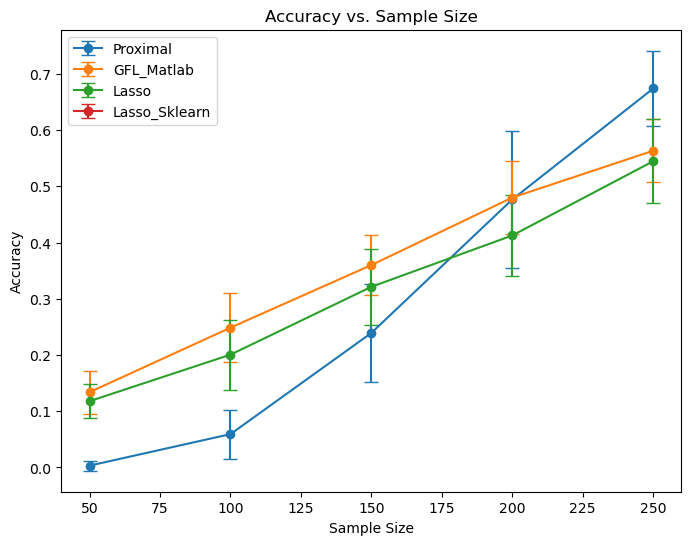

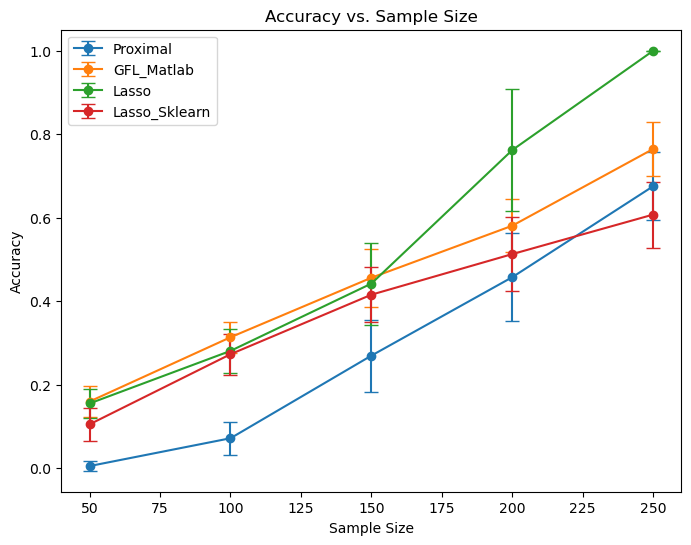

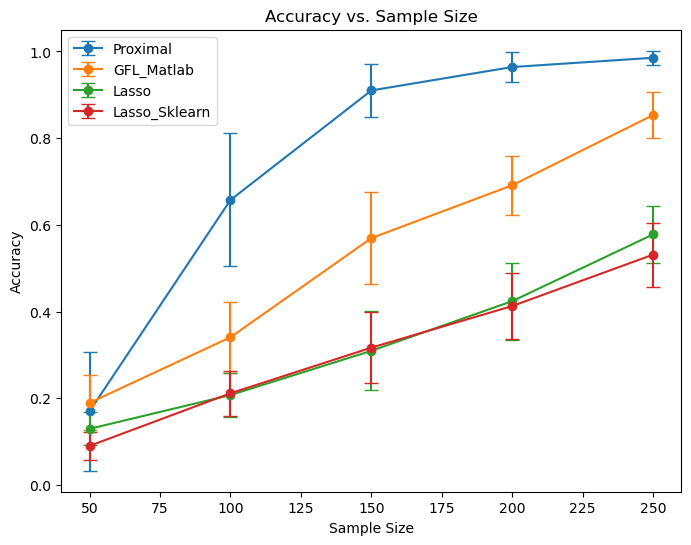

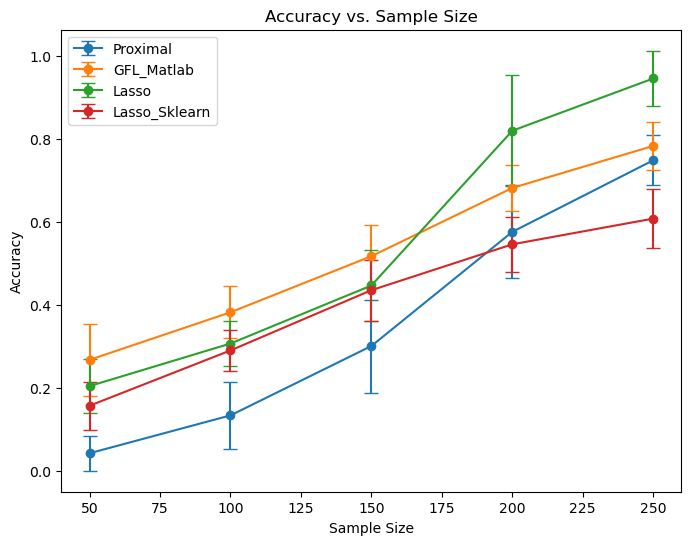

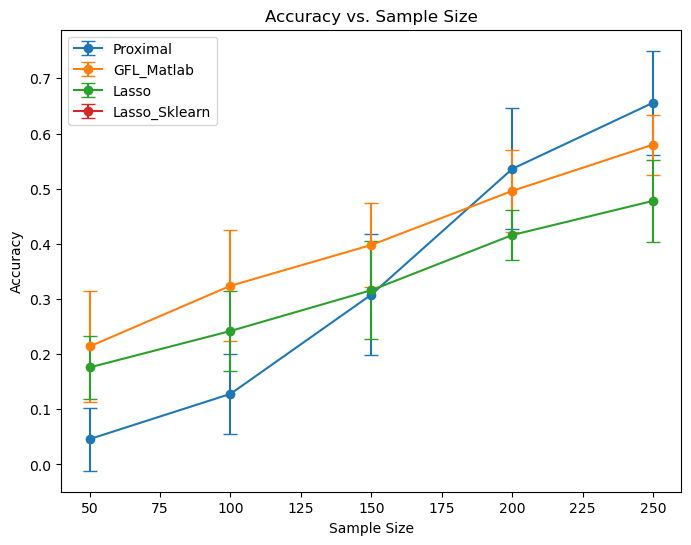

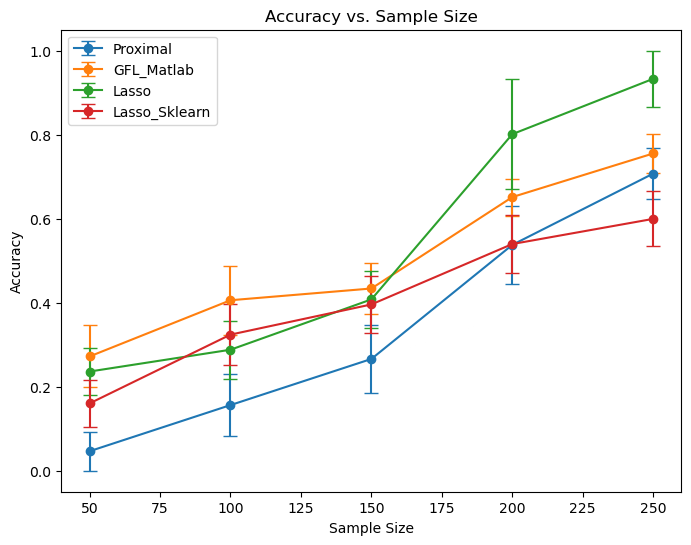

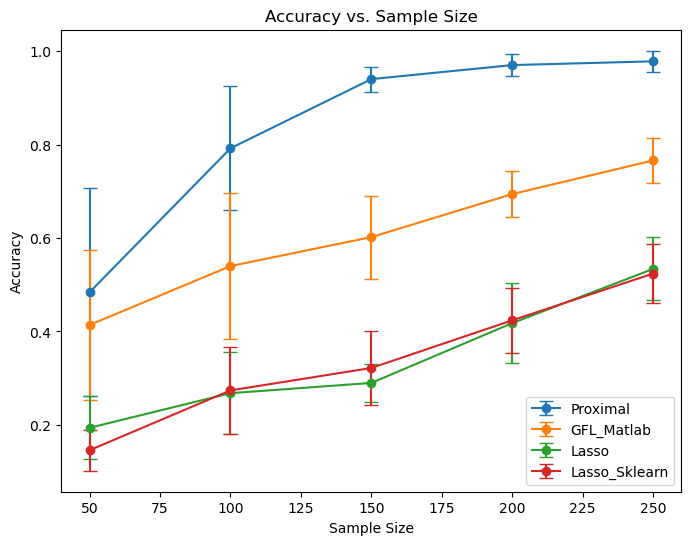

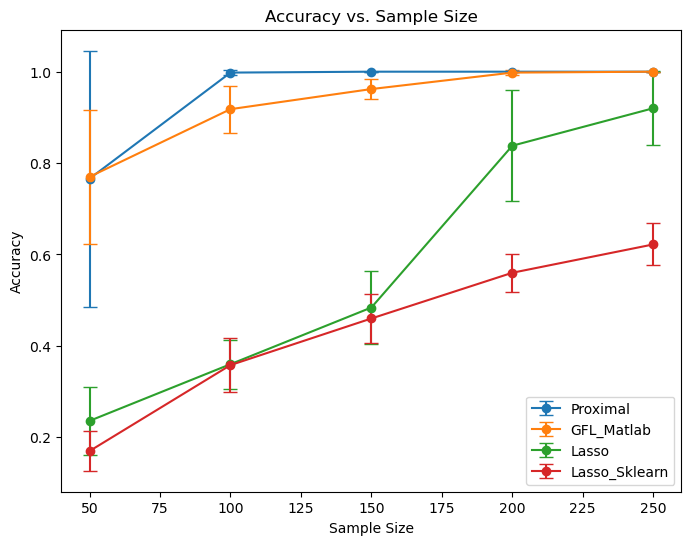

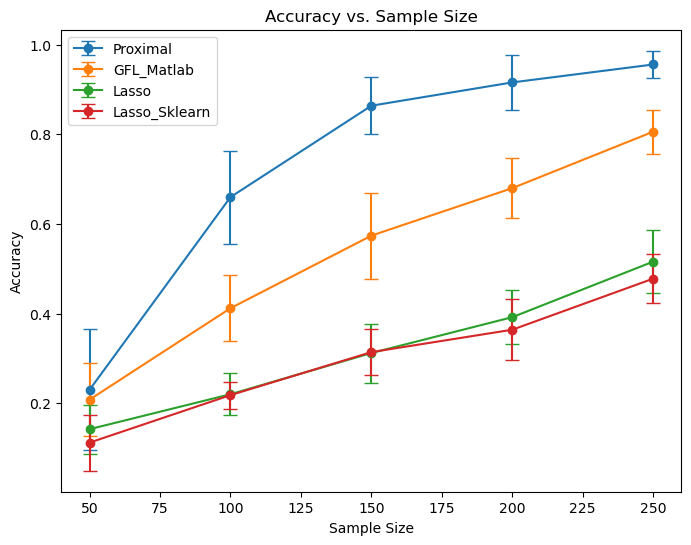

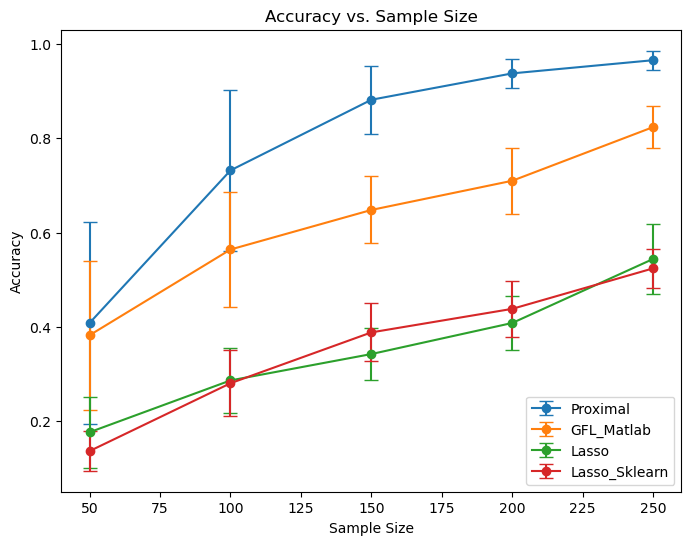

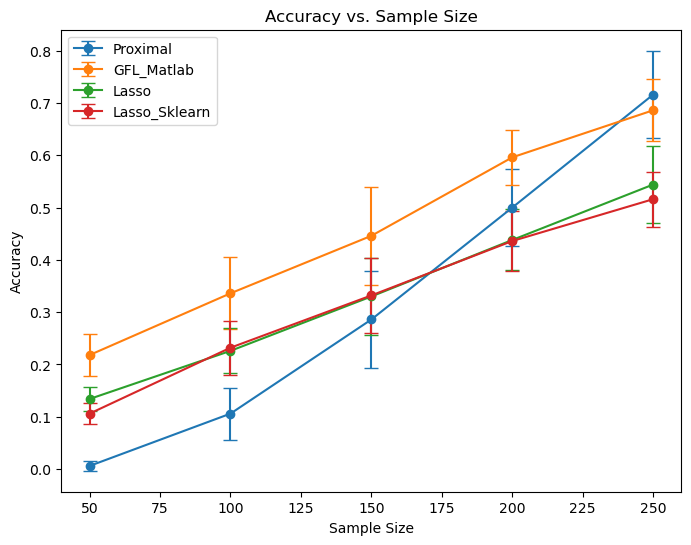

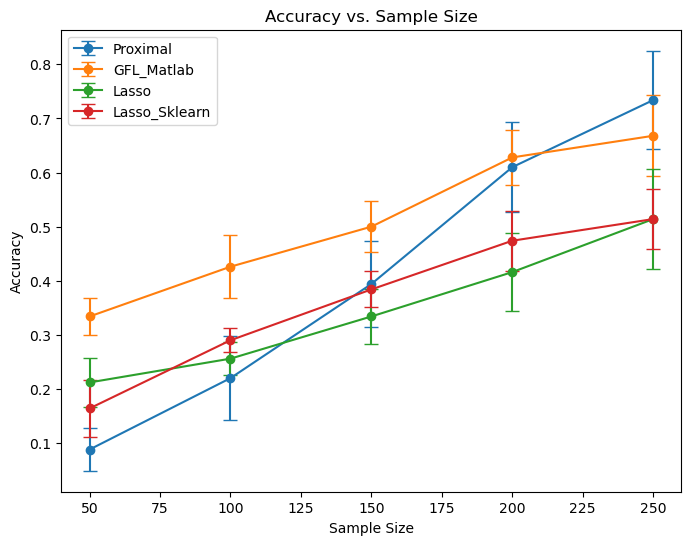

In [46]:
# write a function to plot the results
def analysis(accuracy):
    acc_1, acc_2, acc_3, acc_4 = [], [], [], []
    std_1, std_2, std_3, std_4 = [], [], [], []

    for i in range(len(accuracy)):
        mean_1 = np.mean(accuracy[i]['Proximal'])
        stddev_1 = np.std(accuracy[i]['Proximal'])
        acc_1.append(mean_1)
        std_1.append(stddev_1)

        mean_2 = np.mean(accuracy[i]['GFL_Matlab'])
        stddev_2 = np.std(accuracy[i]['GFL_Matlab'])
        acc_2.append(mean_2)
        std_2.append(stddev_2)

        mean_3 = np.mean(accuracy[i]['Lasso'])
        stddev_3 = np.std(accuracy[i]['Lasso'])
        acc_3.append(mean_3)
        std_3.append(stddev_3)

        mean_4 = np.mean(accuracy[i]['Lasso_Sklearn'])
        stddev_4 = np.std(accuracy[i]['Lasso_Sklearn'])
        acc_4.append(mean_4)
        std_4.append(stddev_4)

    
    plt.figure(figsize=(8, 6))
    plt.errorbar(sample_sizes, acc_1, yerr=std_1, fmt='o-', label='Proximal', capsize=5)
    plt.errorbar(sample_sizes, acc_2, yerr=std_2, fmt='o-', label='GFL_Matlab', capsize=5)
    plt.errorbar(sample_sizes, acc_3, yerr=std_3, fmt='o-', label='Lasso', capsize=5)
    plt.errorbar(sample_sizes, acc_4, yerr=std_4, fmt='o-', label='Lasso_Sklearn', capsize=5)
    plt.xlabel('Sample Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Sample Size')
    plt.legend()
    plt.show()

accuracys = [accuracy_2, accuracy_3, accuracy_4, accuracy_11, accuracy_22, accuracy_33, accuracy_44, accuracy_55, accuracy_6, accuracy_66, accuracy_7, accuracy_77]

for acc in accuracys:
    analysis(acc)
    

In [47]:
accuracy_88 = []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=10, h_selected=2, h_rest=8, 
                                     gamma=0.5, p=0.95, q=0.2, 
                                     num_replications=10)
    accuracy_77.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.324
rho: 7.0710678118654755, mu: 0.1, acc: 0.34400000000000003
rho: 7.0710678118654755, mu: 1.0, acc: 0.34400000000000003
rho: 48.08326112068523, mu: 0.01, acc: 0.336
rho: 48.08326112068523, mu: 0.1, acc: 0.348
rho: 48.08326112068523, mu: 1.0, acc: 0.352
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
1 3
1 3
1 3
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
3 5
3 5
3 5
3 5
3 5
3 5
3 5
3 5
1 3
1 3
1 3
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
13 15
13 15
13 15
13 15
13 15
13 15
13 15
13 15
13 15
13 15
8 10
7 9
6 8
4

In [50]:
len(accuracy_77)

10

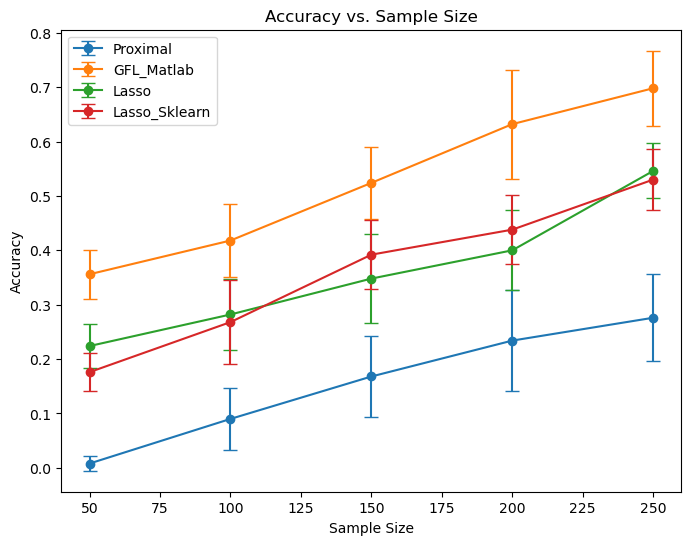

In [51]:
analysis(accuracy_77[5:])

In [52]:
accuracy_10 = []
sample_sizes = np.arange(50, 500, 50)
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=10, h_selected=2, h_rest=8, 
                                     gamma=0.5, p=0.95, q=0.2, 
                                     num_replications=20)
    accuracy_10.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.21200000000000002
rho: 7.0710678118654755, mu: 0.1, acc: 0.21600000000000003
rho: 7.0710678118654755, mu: 1.0, acc: 0.20800000000000002
rho: 48.08326112068523, mu: 0.01, acc: 0.22400000000000003
rho: 48.08326112068523, mu: 0.1, acc: 0.22400000000000003
rho: 48.08326112068523, mu: 1.0, acc: 0.22000000000000003
Best rho: 48.08326112068523, Best mu: 0.01
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
10 12
10 12
10 12
10 12
10 12
10 12
10 12
10 12
10 12
10 12
9 11
8 10
5 7
4 6
4 6
4 6
3 5
3 5
3 5
3 5
3 5
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Syn

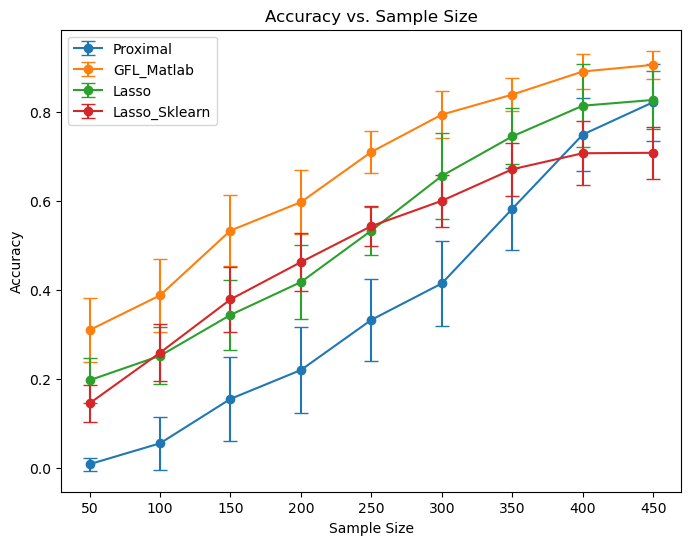

In [53]:
analysis(accuracy_10)

In [54]:
accuracy_20 = []
sample_sizes = np.arange(50, 800, 100)
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=10, h_selected=2, h_rest=8, 
                                     gamma=0.5, p=0.95, q=0.2, 
                                     num_replications=10)
    accuracy_20.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.364
rho: 7.0710678118654755, mu: 0.1, acc: 0.36
rho: 7.0710678118654755, mu: 1.0, acc: 0.36
rho: 48.08326112068523, mu: 0.01, acc: 0.364
rho: 48.08326112068523, mu: 0.1, acc: 0.364
rho: 48.08326112068523, mu: 1.0, acc: 0.364
Best rho: 7.0710678118654755, Best mu: 0.01
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
13 15
13 15
13 15
13 15
13 15
13 15
13 15
13 15
13 15
13 15
10 12
9 11
6 8
4 6
4 6
3 5
3 5
3 5
3 5
3 5
3 5
2 4
3 5
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
9 11
9 11
9 11
9 11
9 11
9 11
9 11
9 11
9 11
6 8
5 7
3 5
2 4
2 4
2 4
2 4
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
3 5
3 5
3 

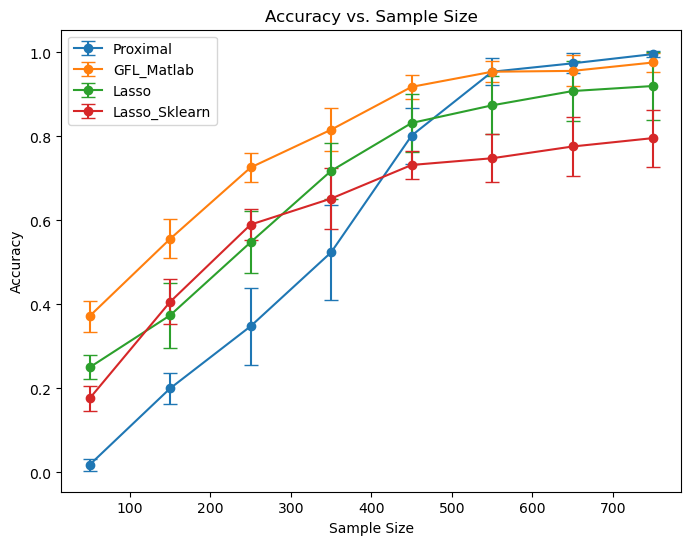

In [55]:
analysis(accuracy_20)

In [56]:
accuracy_30 = []
sample_sizes = np.arange(50, 1000, 100)
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=10, h_selected=2, h_rest=8, 
                                     gamma=0.5, p=0.95, q=0.25, 
                                     num_replications=20)
    accuracy_30.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.312
rho: 7.0710678118654755, mu: 0.1, acc: 0.316
rho: 7.0710678118654755, mu: 1.0, acc: 0.316
rho: 48.08326112068523, mu: 0.01, acc: 0.308
rho: 48.08326112068523, mu: 0.1, acc: 0.308
rho: 48.08326112068523, mu: 1.0, acc: 0.324
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
1 3
1 3
1 3
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6
1 3
1 3
1 3
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 3: Running Lasso_Sklearn model
Synth

Unexpected unknown exception from MEX file..

Error in eff_general_flsa (line 10)
    [w omega]  = mexEFLSA(n, z, lambda1, lambda2, nE, E_in, E_out, E_w, 0);
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Error in fast_gfl (line 68)
        beta_zp = eff_general_flsa(length(vg), vg, rho1/gamma, rho2*rho1/gamma, nE, E_in, E_out, E_w);
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Error in gfl_proximal (line 25)
    [beta, funcVal] = fast_gfl(X, y, Graph, rho1, rho2, opts);
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



MatlabExecutionError: 
  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/code_fgfl_aaai14/eff_general_flsa.m, line 10, in eff_general_flsa

  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/code_fgfl_aaai14/fast_gfl.m, line 68, in fast_gfl

  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/code_fgfl_aaai14/gfl_proximal.m, line 25, in gfl_proximal
Unexpected unknown exception from MEX file..


In [57]:
accuracy_40 = []
sample_sizes = np.arange(50, 1000, 100)
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=10, h_selected=2, h_rest=8, 
                                     gamma=0.5, p=0.95, q=0.25, 
                                     num_replications=20)
    accuracy_40.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.316
rho: 7.0710678118654755, mu: 0.1, acc: 0.332
rho: 7.0710678118654755, mu: 1.0, acc: 0.34400000000000003
rho: 48.08326112068523, mu: 0.01, acc: 0.32
rho: 48.08326112068523, mu: 0.1, acc: 0.336
rho: 48.08326112068523, mu: 1.0, acc: 0.34800000000000003
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 3: Running Lasso_Skle

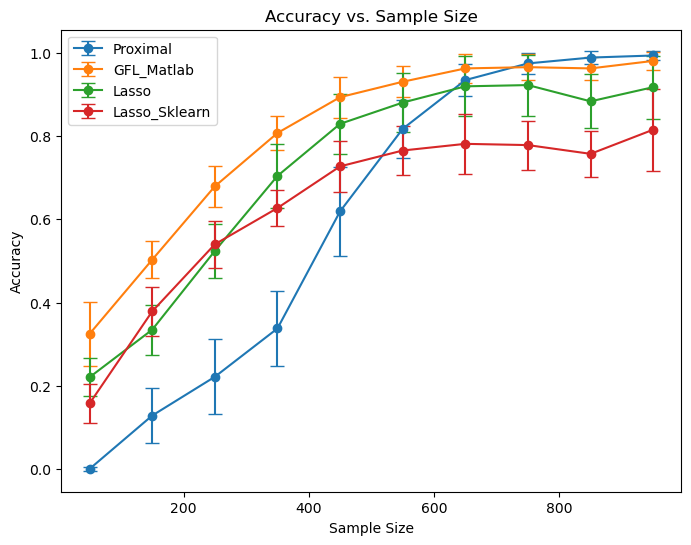

In [58]:
analysis(accuracy_40)

In [61]:
accuracy_50 = []
sample_sizes = np.arange(50, 1000, 100)
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelationWeight(n=n, d=1000, k=50, 
                                     h_total=10, h_selected=2, h_rest=8, 
                                     gamma=0.5, p=0.95, q=0.25, 
                                     num_replications=20)
    accuracy_50.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.21200000000000002
rho: 7.0710678118654755, mu: 0.1, acc: 0.22400000000000003
rho: 7.0710678118654755, mu: 1.0, acc: 0.23199999999999998
rho: 48.08326112068523, mu: 0.01, acc: 0.22000000000000003
rho: 48.08326112068523, mu: 0.1, acc: 0.24
rho: 48.08326112068523, mu: 1.0, acc: 0.248
Best rho: 48.08326112068523, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
1 3
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 4: Running GFL_Matlab model
Synthetic dataset 4: Running Lasso m

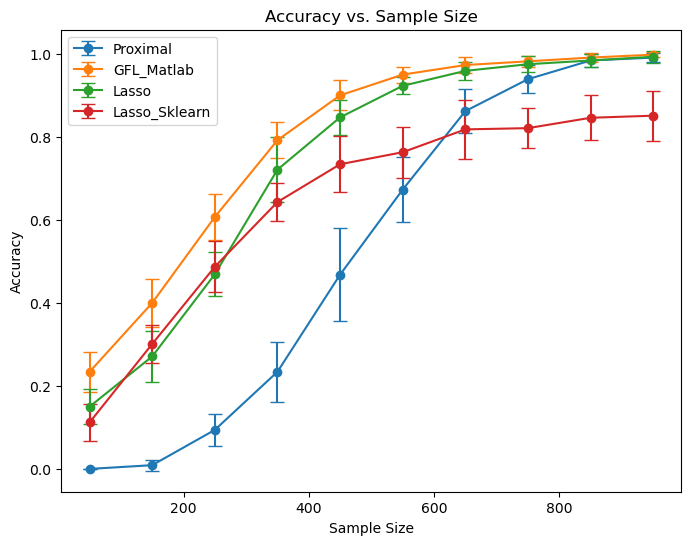

In [62]:
analysis(accuracy_50)

In [71]:
accuracy_41 = []
sample_sizes = np.arange(50, 1000, 100)
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=2, h_selected=1, h_rest=1, 
                                     gamma=0.5, p=0.9, q=0.2, 
                                     num_replications=10)
    accuracy_41.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.544
rho: 7.0710678118654755, mu: 0.1, acc: 0.528
rho: 7.0710678118654755, mu: 1.0, acc: 0.508
rho: 48.08326112068523, mu: 0.01, acc: 0.536
rho: 48.08326112068523, mu: 0.1, acc: 0.512
rho: 48.08326112068523, mu: 1.0, acc: 0.508
Best rho: 7.0710678118654755, Best mu: 0.01
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
6 8
6 8
6 8
6 8
6 8
6 8
6 8
6 8
6 8
5 7
3 5
2 4
2 4
2 4
2 4
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
5 7
5 7
5 7
5 7
5 7
5 7
5 7
5 7
2 4
1 3
1 3
1 3
Synthetic dataset 3: Running

In [73]:
len(accuracy_51)

9

In [72]:
accuracy_51 = []
sample_sizes = np.arange(50, 1000, 100)
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelationWeight(n=n, d=1000, k=50, 
                                     h_total=2, h_selected=1, h_rest=1, 
                                     gamma=0.5, p=0.9, q=0.2, 
                                     num_replications=10)
    accuracy_51.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.356
rho: 7.0710678118654755, mu: 0.1, acc: 0.364
rho: 7.0710678118654755, mu: 1.0, acc: 0.36
rho: 48.08326112068523, mu: 0.01, acc: 0.356
rho: 48.08326112068523, mu: 0.1, acc: 0.352
rho: 48.08326112068523, mu: 1.0, acc: 0.356
Best rho: 7.0710678118654755, Best mu: 0.1
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
1 3
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 4: Running GFL_Matlab model
Synthetic dataset 4: Running Lasso model
Synthetic data

AttributeError: 'NoneType' object has no attribute 'quit'

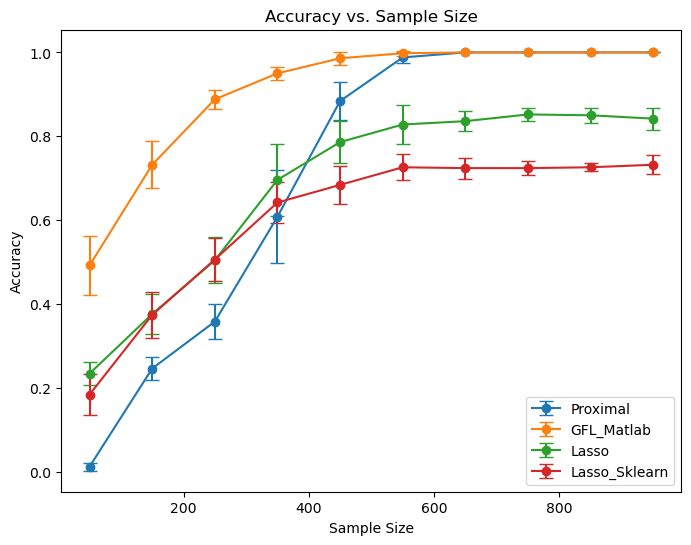

In [75]:
analysis(accuracy_41)

In [78]:
# save all the accuracies to a file
import pickle
accuracys = [accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5, accuracy_6, 
             accuracy_7, accuracy_11, accuracy_22, accuracy_33, accuracy_44, accuracy_55, accuracy_66, accuracy_77, accuracy_88, 
             accuracy_10, accuracy_20, accuracy_30, accuracy_40, accuracy_50, accuracy_41, accuracy_51]
with open('accuracies.pkl', 'wb') as f:
    pickle.dump(accuracys, f)


In [14]:
# read the accuracies from the file
with open('accuracies.pkl', 'rb') as f:
    accuracys = pickle.load(f)

# plot the accuracies
import matplotlib.pyplot as plt

def analysis(accuracy, j):
    acc_1, acc_2, acc_3, acc_4 = [], [], [], []
    std_1, std_2, std_3, std_4 = [], [], [], []

    for i in range(len(accuracy)):
        mean_1 = np.mean(accuracy[i]['Proximal'])
        stddev_1 = np.std(accuracy[i]['Proximal'])
        acc_1.append(mean_1)
        std_1.append(stddev_1)

        mean_2 = np.mean(accuracy[i]['GFL_Matlab'])
        stddev_2 = np.std(accuracy[i]['GFL_Matlab'])
        acc_2.append(mean_2)
        std_2.append(stddev_2)

        mean_3 = np.mean(accuracy[i]['Lasso'])
        stddev_3 = np.std(accuracy[i]['Lasso'])
        acc_3.append(mean_3)
        std_3.append(stddev_3)

        mean_4 = np.mean(accuracy[i]['Lasso_Sklearn'])
        stddev_4 = np.std(accuracy[i]['Lasso_Sklearn'])
        acc_4.append(mean_4)
        std_4.append(stddev_4)

    
    plt.figure(figsize=(8, 6))
    plt.errorbar(sample_sizes[:len(accuracy)], acc_1, yerr=std_1, fmt='o-', label='Proximal', capsize=5)
    plt.errorbar(sample_sizes[:len(accuracy)], acc_2, yerr=std_2, fmt='o-', label='GFL_Matlab', capsize=5)
    plt.errorbar(sample_sizes[:len(accuracy)], acc_3, yerr=std_3, fmt='o-', label='Lasso', capsize=5)
    plt.errorbar(sample_sizes[:len(accuracy)], acc_4, yerr=std_4, fmt='o-', label='Lasso_Sklearn', capsize=5)
    plt.xlabel('Sample Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Sample Size')
    plt.legend()
    pdf_filename = f"output_{j}.pdf"
    plt.savefig(pdf_filename, bbox_inches='tight')
    plt.show()

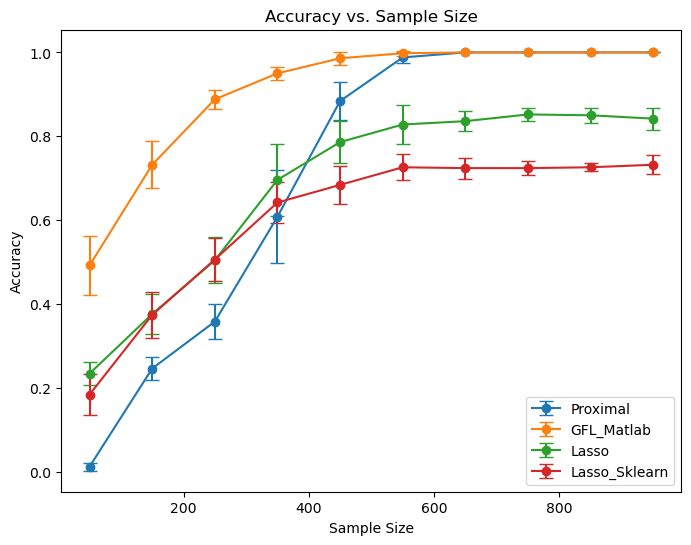

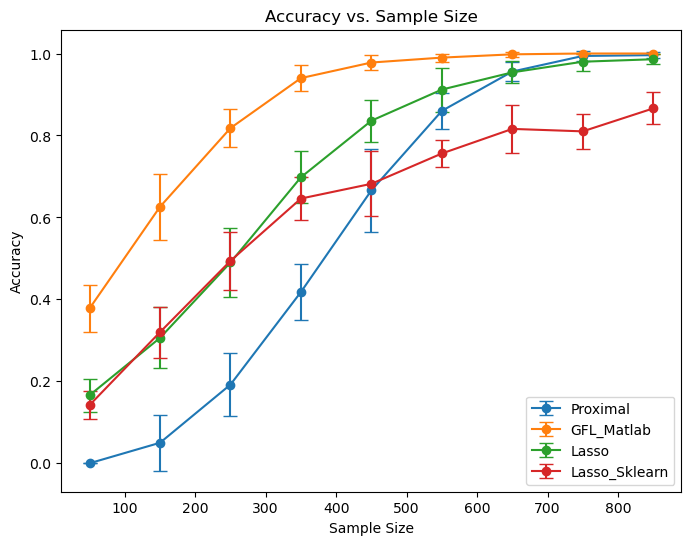

In [15]:
i = 0
for acc in accuracys[-2:]:
    i += 1
    sample_sizes = np.arange(50, 1000, 100)
    analysis(acc, i)

In [4]:
len(accuracys)

22

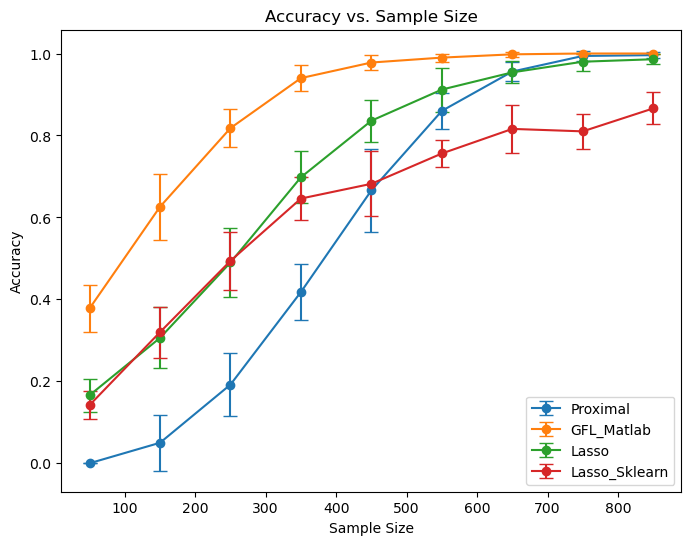

In [77]:
sample_sizes = np.arange(50, 900, 100)
analysis(accuracy_51)